## ☁️ Connect G-Drive

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Homework 2 AN2DL condivisa/ DeepLabV3 (No Aliens)

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/1SjZ_-XjkG_FsuR9orhSxIGp-dNxNdzS1/Homework 2 AN2DL condivisa/ DeepLabV3 (No Aliens)


## ⚒️ Import libraries


In [2]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display settings
#sns.set(font_scale=1.4)
sns.set_style('white')
#plt.rc('font', size=14)
%matplotlib inline

2.17.1


In [3]:
# Seed for reproducibility
seed = 42

# Load the dataset
data = np.load("../Datasets/Dataset_cleaned.npz")
X_train = data["training_set"][0, :]
y_train = data["training_set"][1, :]
X_test = data["test_set"]

# Split into training and validation sets
train_img, val_img, train_lbl, val_lbl = train_test_split(
    X_train, y_train, test_size=0.1, random_state=seed
)

In [4]:
# Set batch size for training
BATCH_SIZE = 16

# Set learning rate for the optimiser
LEARNING_RATE = 1e-3

# Set early stopping patience threshold
PATIENCE = 20

# Set maximum number of training epochs
EPOCHS = 1000

# Number of classes
NUM_CLASSES = 5

## 📈 Parameters & Network

In [5]:
# Split the paths (not the data) into training, validation, and test sets
print("Splitting data...")
train_val_img, test_img, train_val_lbl, test_lbl = train_test_split(
    X_train, y_train, test_size=0.1, random_state=seed
)

train_img, val_img, train_lbl, val_lbl = train_test_split(
    train_val_img, train_val_lbl, test_size=0.1, random_state=seed
)

print("Data splitted!")

print(f"\nNumber of images:")
print(f"Train: {len(train_img)}")
print(f"Validation: {len(val_img)}")
print(f"Test: {len(test_img)}")

del train_val_img, train_val_lbl

Splitting data...
Data splitted!

Number of images:
Train: 2028
Validation: 226
Test: 251


In [6]:
def make_dataset(image_paths, label_paths, batch_size, shuffle=True, augment=False, seed=None):
    """
    Create a memory-efficient TensorFlow dataset.
    """
    # Create dataset from file paths
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_paths))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [7]:
# Create the datasets
print("Creating datasets...")

train_dataset = make_dataset(
    train_img, train_lbl,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=True,
    seed=seed
)

val_dataset = make_dataset(
    val_img, val_lbl,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_dataset = make_dataset(
    test_img, test_lbl,
    batch_size=BATCH_SIZE,
    shuffle=False
)


print("Datasets created!")

# Check the shape of the data
for images, labels in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"\nInput shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    break

Creating datasets...
Datasets created!

Input shape: (64, 128)
Images shape: (16, 64, 128)
Labels shape: (16, 64, 128)
Labels dtype: <dtype: 'float64'>


In [8]:
import tensorflow as tf
from tensorflow.keras import layers, Model

In [9]:
def atrous_spatial_pyramid_pooling(inputs, filters=256):
    """
    Atrous Spatial Pyramid Pooling (ASPP) module.
    """
    # Atrous Convolutions with different dilation rates
    conv1 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(inputs)
    conv3_6 = layers.Conv2D(filters, (3, 3), padding='same', dilation_rate=6, activation='relu')(inputs)
    conv3_12 = layers.Conv2D(filters, (3, 3), padding='same', dilation_rate=12, activation='relu')(inputs)
    conv3_18 = layers.Conv2D(filters, (3, 3), padding='same', dilation_rate=18, activation='relu')(inputs)

    # Global Average Pooling
    global_avg_pool = layers.GlobalAveragePooling2D()(inputs)
    global_avg_pool = layers.Reshape((1, 1, inputs.shape[-1]))(global_avg_pool)
    global_avg_pool = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(global_avg_pool)
    global_avg_pool = layers.UpSampling2D(size=(inputs.shape[1], inputs.shape[2]), interpolation='bilinear')(global_avg_pool)

    # Concatenate all features
    x = layers.Concatenate()([conv1, conv3_6, conv3_12, conv3_18, global_avg_pool])
    x = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(x)
    return x

In [10]:
# Simplified DeepLabV3 Model
def simplified_deeplabv3(input_shape=(64, 128, 1), num_classes=2):  # Update num_classes if needed
    inputs = layers.Input(shape=input_shape)

    # Encoder: Feature Extraction
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)  # Downsample

    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)  # Downsample

    x = layers.Conv2D(512, (3, 3), padding='same', activation='relu')(x)

    # Atrous Spatial Pyramid Pooling
    aspp = atrous_spatial_pyramid_pooling(x)

    # Decoder: Upsampling
    x = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(aspp)
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)

    x = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(x)
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)

    # Output layer for multi-class
    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(x)

    model = Model(inputs, outputs)
    return model



In [11]:

# Mean IntersectionOverUnion as metric
mean_iou = tfk.metrics.MeanIoU(num_classes=NUM_CLASSES, ignore_class=0, sparse_y_pred=False)


In [12]:
# Compile the Model
model = simplified_deeplabv3(input_shape=(64, 128, 1), num_classes=NUM_CLASSES)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy', mean_iou]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 64, 128, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 64, 128, 64)    │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 64, 128, 128)   │         73,856 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 32, 64, 128)    │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 64, 256)    │        295,168 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 16, 32, 256)    │              0 │ conv2d_2[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 16, 32, 512)    │      1,180,160 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 512)            │              0 │ conv2d_3[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 1, 512)      │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 1, 1, 256)      │        131,328 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 16, 32, 256)    │        131,328 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 16, 32, 256)    │      1,179,904 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 32, 256)    │      1,179,904 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 16, 32, 256)    │      1,179,904 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 16, 32, 256)    │              0 │ conv2d_8[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 16, 32, 1280)   │              0 │ conv2d_4[0][0],        │
│                           │                        │                │ conv2d_5[0][0],        │
│                           │                        │                │ conv2d_6[0][0],        │
│                           │                        │                │ conv2d_7[0][0],        │
│                      

 Total params: 6,565,893 (25.05 MB)

 Trainable params: 6,565,893 (25.05 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',  # Metrica da monitorare
    factor=0.5,              # Riduce il learning rate della metà quando non migliora
    patience=3,              # Numero di epochs senza miglioramento prima di ridurre il learning rate
    min_lr=1e-5,             # Limite minimo del learning rate
    verbose=1                # Mostra messaggi quando il learning rate viene modificato
)

#viz_callback = VizCallback(val_img[0], val_lbl[0])

In [14]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping, reduce_lr],#, viz_callback],
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_io_u'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'DeepLabV3_'+str(final_val_meanIoU)+'.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

Epoch 1/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 101s 502ms/step - accuracy: 0.3241 - loss: 1.3800 - mean_io_u: 0.1180 - val_accuracy: 0.5879 - val_loss: 1.0624 - val_mean_io_u: 0.2504 - learning_rate: 1.0000e-04
Epoch 2/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 69s 192ms/step - accuracy: 0.4941 - loss: 1.1499 - mean_io_u: 0.2268 - val_accuracy: 0.6104 - val_loss: 0.9914 - val_mean_io_u: 0.2518 - learning_rate: 1.0000e-04
Epoch 3/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 195ms/step - accuracy: 0.5527 - loss: 1.0516 - mean_io_u: 0.2664 - val_accuracy: 0.6671 - val_loss: 0.8672 - val_mean_io_u: 0.3370 - learning_rate: 1.0000e-04
Epoch 4/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 25s 195ms/step - accuracy: 0.6026 - loss: 1.0106 - mean_io_u: 0.3049 - val_accuracy: 0.6845 - val_loss: 0.8317 - val_mean_io_u: 0.3490 - learning_rate: 1.0000e-04
Epoch 5/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 194ms/step - accuracy: 0.6324 - loss: 0.9358 - mean_io_u: 0.3273 - val_accuracy: 0.7036 - val_loss: 0.7680 - val_mean_io_u: 0.3857 - 

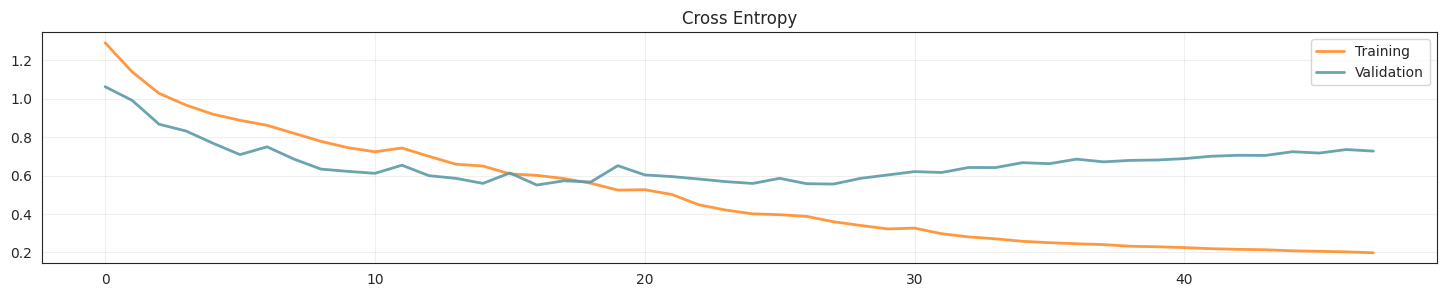

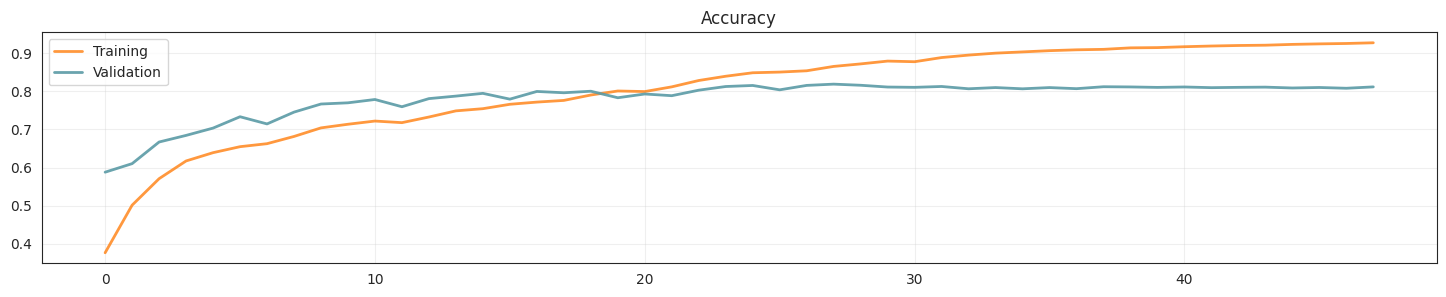

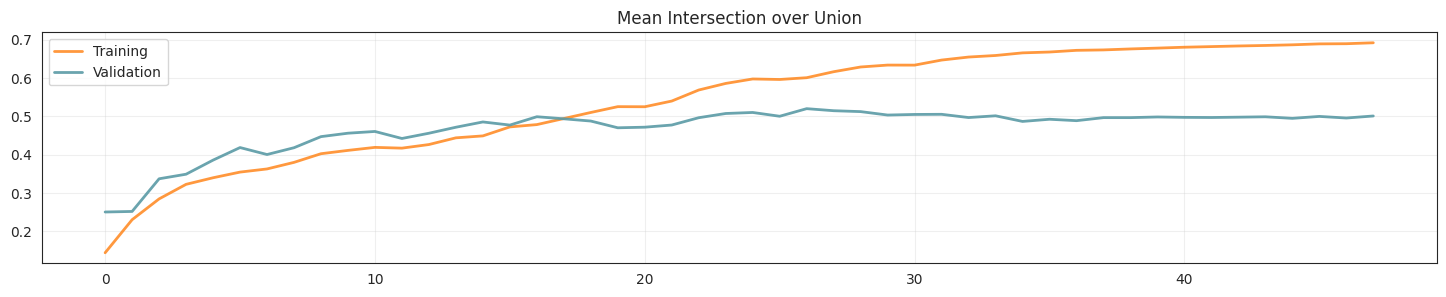

In [15]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_io_u'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_io_u'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer            │ (None, 64, 128, 1)   │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d (Conv2D)        │ (None, 64, 128, 64)  │          640 │ input_layer[0][0]   │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_1 (Conv2D)      │ (None, 64, 128, 128) │       73,856 │ conv2d[0][0]        │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ max_pooling2d          │ (None, 32, 64, 128)  │            0 │ conv2d_1[0][0]      │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_2 (Conv2D)      │ (None, 32, 64, 256)  │      295,168 │ max_pooling2d[0][0] │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ max_pooling2d_1        │ (None, 16, 32, 256)  │            0 │ conv2d_2[0][0]      │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_3 (Conv2D)      │ (None, 16, 32, 512)  │    1,180,160 │ max_pooling2d_1[0]… │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ global_average_poolin… │ (None, 512)          │            0 │ conv2d_3[0][0]      │    -    │
│ (GlobalAveragePooling… │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ reshape (Reshape)      │ (None, 1, 1, 512)    │            0 │ global_average_poo… │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_8 (Conv2D)      │ (None, 1, 1, 256)    │      131,328 │ reshape[0][0]       │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_4 (Conv2D)      │ (None, 16, 32, 256)  │      131,328 │ conv2d_3[0][0]      │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_5 (Conv2D)      │ (None, 16, 32, 256)  │    1,179,904 │ conv2d_3[0][0]      │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_6 (Conv2D)      │ (None, 16, 32, 256)  │    1,179,904 │ conv2d_3[0][0]      │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_7 (Conv2D)      │ (None, 16, 32, 256)  │    1,179,904 │ conv2d_3[0][0]      │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ up_sampling2d          │ (None, 16, 32, 256)  │            0 │ conv2d_8[0][0]      │    -    │
│ (UpSampling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ concatenate            │ (None, 16, 32, 1280) │            0 │ conv2d_4[0][0],     │    -    │
│ (Concatenate)          │                      │              │ conv2d_5[0][0],     │         │
│                        │                      │              │ conv2d_6[0][0],     │         │
│                      

 Total params: 6,565,893 (25.05 MB)

 Trainable params: 6,565,893 (25.05 MB)

 Non-trainable params: 0 (0.00 B)

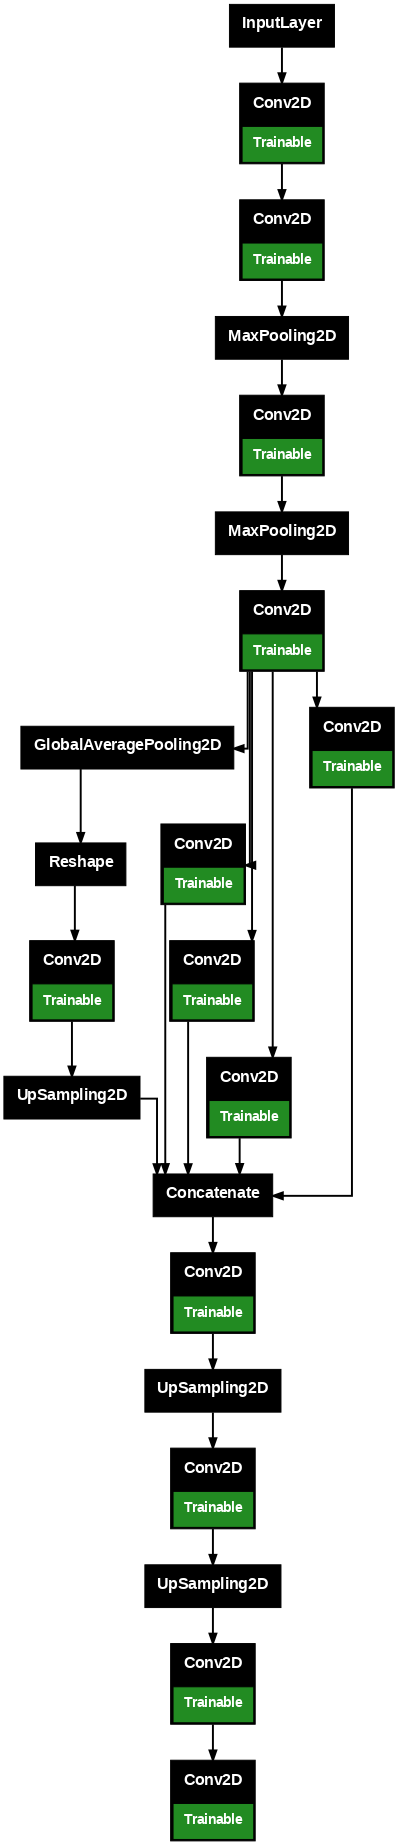

In [17]:
# Load UNet model without compiling
model_filename = 'DeepLabV3_52.0.keras'
model = tfk.models.load_model(model_filename, compile=False)

# Compile the model with specified loss, optimizer, and metrics
model.compile(optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy", mean_iou])

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

In [18]:
# Evaluate the model on the test set and print the results
test_loss, test_accuracy, test_mean_iou = model.evaluate(test_dataset, verbose=1, batch_size=10)
print(f'Test Accuracy: {round(test_accuracy, 4)}')
print(f'Test Mean Intersection over Union: {round(test_mean_iou, 4)}')

16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 648ms/step - accuracy: 0.7580 - loss: 0.7645 - mean_io_u: 0.4936
Test Accuracy: 0.7848
Test Mean Intersection over Union: 0.4944


In [19]:
preds_first = model.predict(test_img)
preds_first = np.argmax(preds_first, axis=-1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step


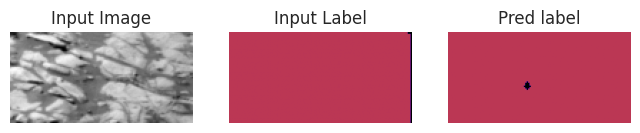

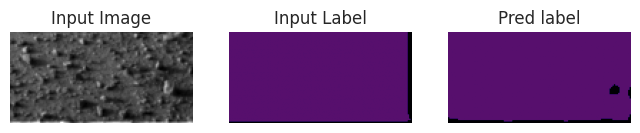

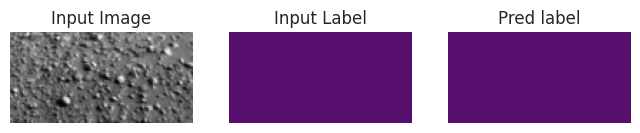

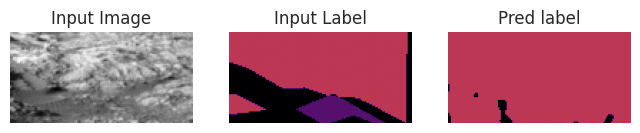

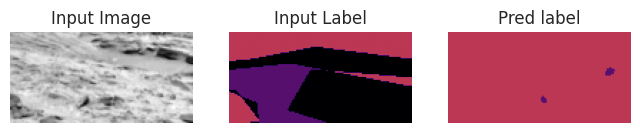

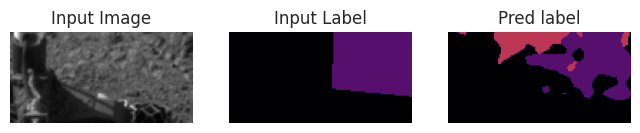

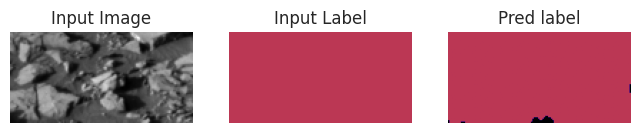

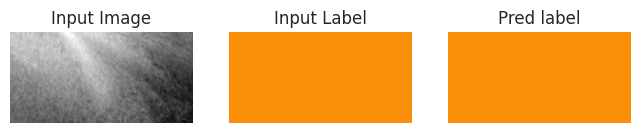

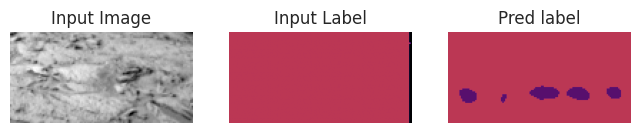

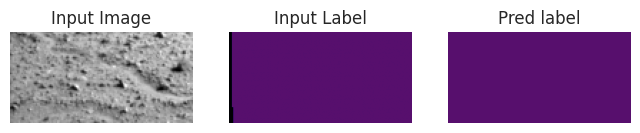

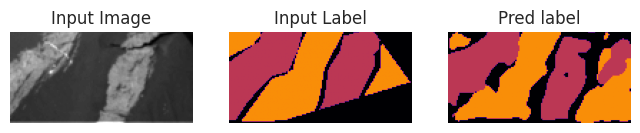

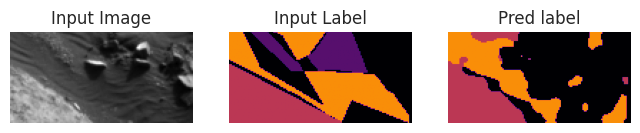

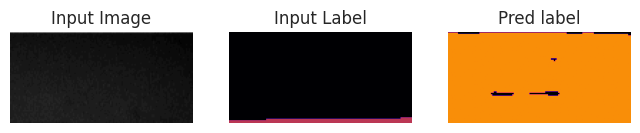

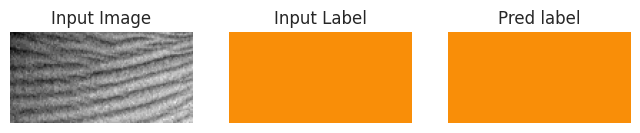

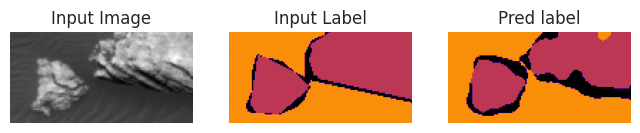

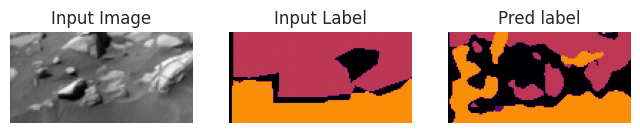

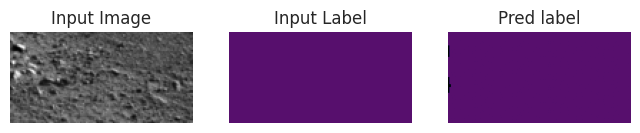

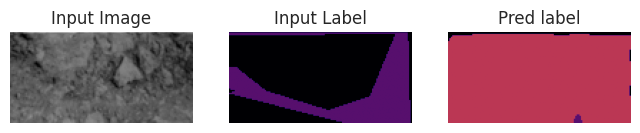

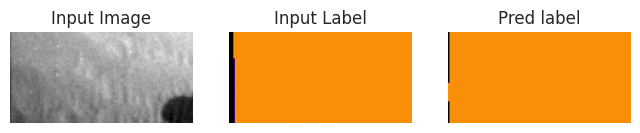

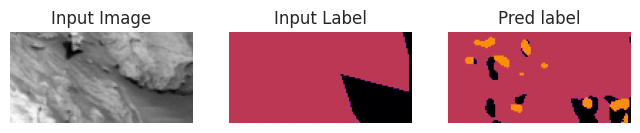

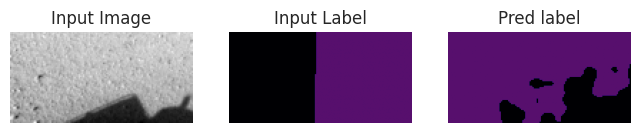

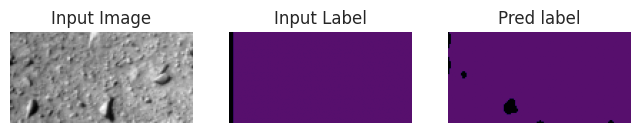

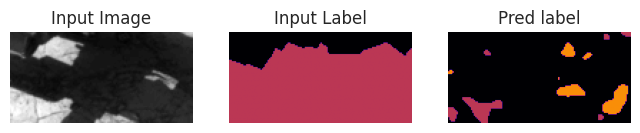

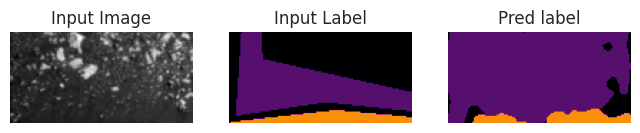

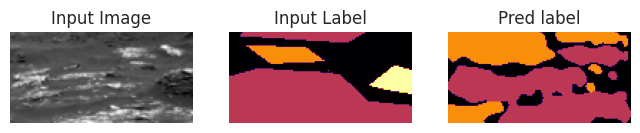

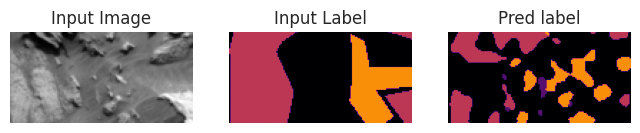

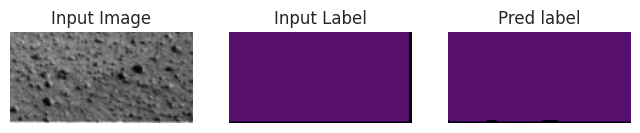

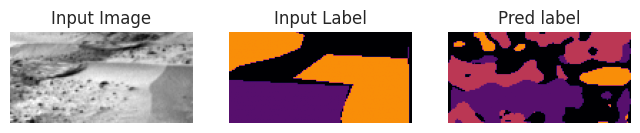

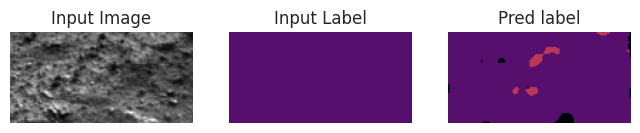

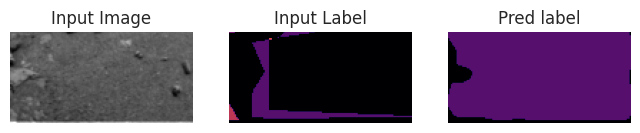

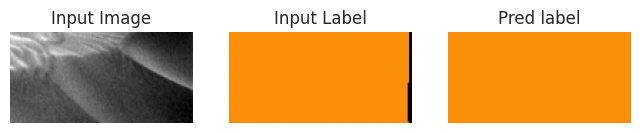

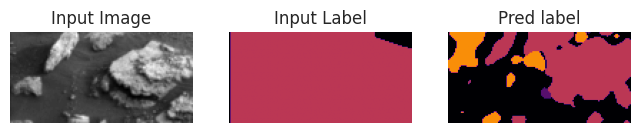

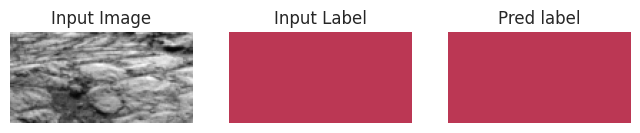

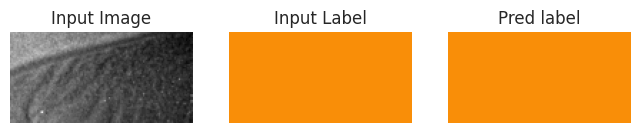

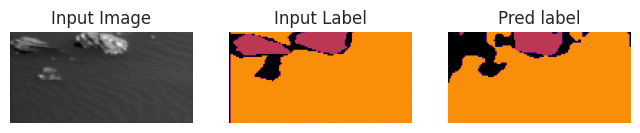

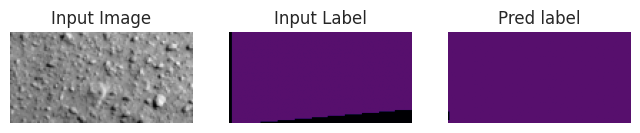

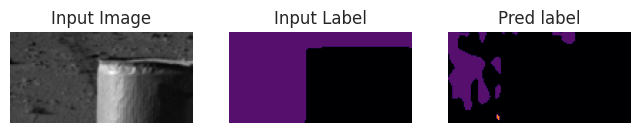

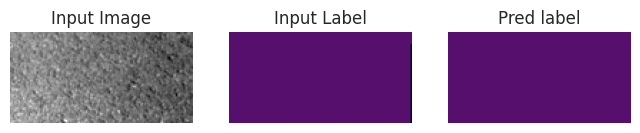

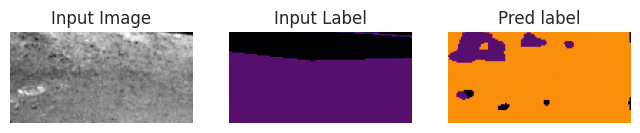

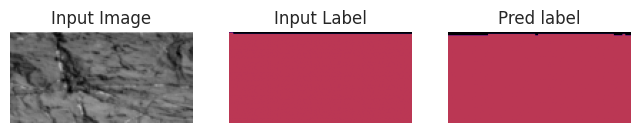

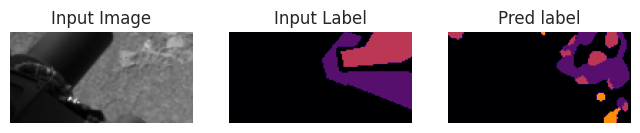

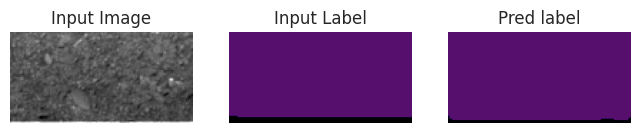

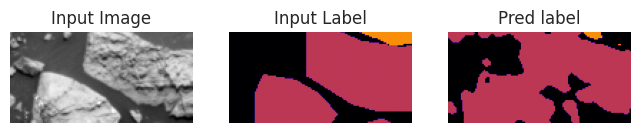

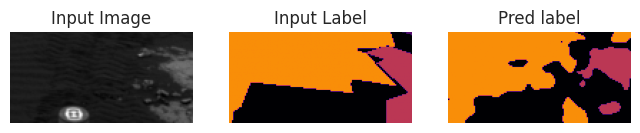

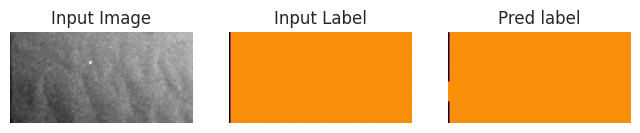

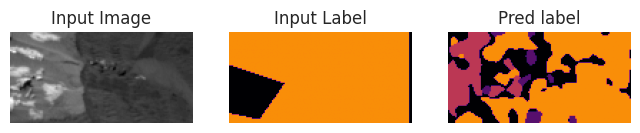

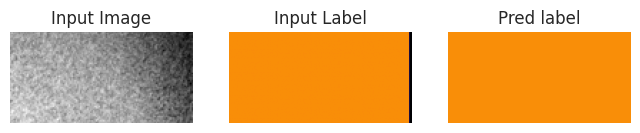

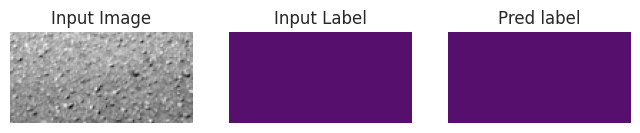

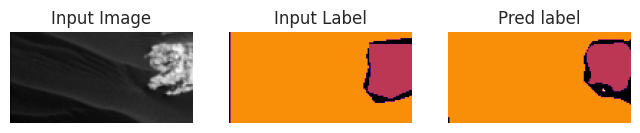

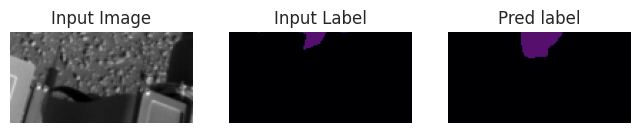

In [20]:
for index in range(50):
  plt.figure(figsize=(8,4))
  plt.subplot(1,3,1)
  plt.imshow(test_img[index], cmap='gray')
  plt.axis('off')
  plt.title("Input Image")
  plt.subplot(1,3,2)
  plt.imshow(test_lbl[index], cmap='inferno',vmin=0,vmax=4)
  plt.axis('off')
  plt.title("Input Label")
  plt.subplot(1,3,3)
  plt.imshow(preds_first[index], cmap='inferno',vmin=0,vmax=4)
  plt.axis('off')
  plt.title("Pred label")
  plt.show()

<Figure size 800x600 with 0 Axes>

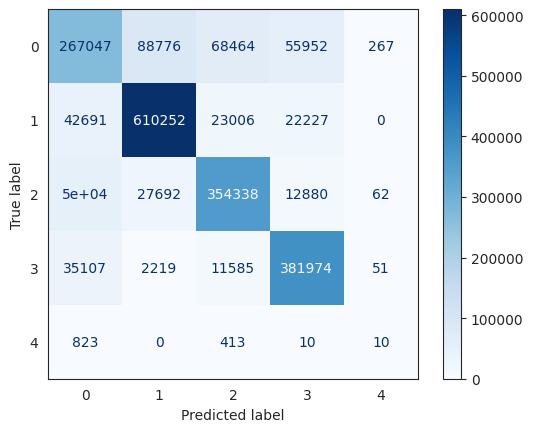

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Flatten the label arrays for comparison
true_labels = test_lbl.flatten()
predicted_labels = preds_first.flatten()

# Compute the confusion matrix
num_classes = 5  # Adjust this based on the number of classes
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=np.arange(num_classes))

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.arange(num_classes))
disp.plot(cmap='Blues')  # Use scientific notation for


## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.




In [22]:
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [23]:
print(model_filename)

DeepLabV3_52.0.keras


In [24]:
# Load model
model = tfk.models.load_model(model_filename)
print(f"Model loaded from {model_filename}")

Model loaded from DeepLabV3_52.0.keras


In [25]:
# Prediction
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 44s 138ms/step
Predictions shape: (10022, 64, 128)


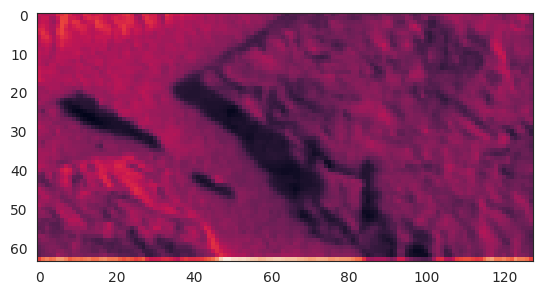

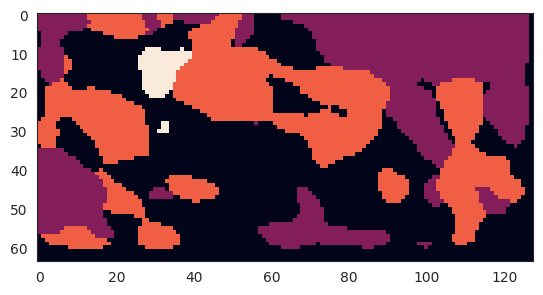

In [26]:
plt.figure()
plt.imshow(X_test[0])
plt.figure()
plt.imshow(preds[0])

In [27]:
import pandas as pd

def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [28]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

from google.colab import files
files.download(submission_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>